<a href="https://colab.research.google.com/github/guilhermegfv/sprint_analisededados/blob/main/Notebook/MVP_AnaliseDeDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUÇÃO

MEIOS DE PAGAMENTO

A entrada do PIX como modalidade de pagamento para os brasileiros é uma iniciativa recente e benéfica para ambos lados. Pelo lado da empresa, representa a menor tarifa de arrecadação a ser paga a instituição bancária, além de contribuir na digitalização do cliente. O objetivo deste projeto, como subsídio para análises internas da área de operação onde trabalho, é entender o crescimento do PIX e como devem ser atribuídas as metas de crescimento para o fim de 2024 e 2025.

FONTE BANCO CENTRAL DADOS ABERTOS

A fonte primária para estudo deste projeto será do próprio governo federal, onde em seu repositório de dados abertos possui uma base de dados com quantidades de transações e montantes somados por modalidade, mês a mês. Assim, será estudado o percentual do uso do PIX pelos brasileiros e alguns padrões de preferência.

DESAFIOS

AA

# IMPORTAR E TRANSFORMAÇÕES

IMPORTAR BIBLIOTECAS

Começaremos importando todas as bibliotecas necessárias neste projeto: pandas, matplotlib.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

FONTE ESTATÍSTICAS DE MEIOS DE PAGAMENTO

A partir desta fonte, serão carregados os dados utilizando o próprio pandas:

https://dadosabertos.bcb.gov.br/dataset/estatisticas-meios-pagamentos

É importante ressaltar que na consulta, o valor 'quantidade' está em milhares e o valor 'valor' está em milhões.

In [2]:
url = "https://olinda.bcb.gov.br/olinda/servico/MPV_DadosAbertos/versao/v1/odata/MeiosdePagamentosMensalDA(AnoMes=@AnoMes)?@AnoMes='202001'&$top=10000&$format=text/csv&$select=AnoMes,quantidadePix,valorPix,quantidadeTED,valorTED,quantidadeTEC,valorTEC,quantidadeCheque,valorCheque,quantidadeBoleto,valorBoleto,quantidadeDOC,valorDOC"
df = pd.read_csv(url)
print(df.head())


   AnoMes quantidadePix    valorPix quantidadeTED    valorTED quantidadeTEC  \
0  202408    5662277,51  2431073,49      67581,13  3621022,65             0   
1  202407    5418285,51  2416378,93      69657,15  3828948,82             0   
2  202406    5278880,88  2179182,85      63599,32  3527912,28             0   
3  202405    5229864,01  2138902,46      69023,11  3482036,97             0   
4  202404    4924838,48  2084927,51      70647,15  3652606,48             0   

  valorTEC quantidadeCheque valorCheque quantidadeBoleto valorBoleto  \
0        0         10009,39    39142,87        343924,99   519248,33   
1        0          10942,8    41504,78        366484,15   546660,21   
2        0          9642,76    36114,74        327754,93   475278,61   
3        0         10467,85    40133,55        349180,92   506302,82   
4        0         11179,22     43295,4        361633,28   524619,69   

  quantidadeDOC valorDOC  
0             0        0  
1             0        0  
2          

TRANSFORMAÇÕES

1) Será corrigida a coluna AnoMes, no format integer YYYYMM para MM/YYYY em date format para correto uso em gráficos

2) Depois, será dividido em dois dataframes, um utilizando quantidade utilizada, e o segundo apenas para tratar montante total.

3) Para cada um desses dois dataframes, será calculado uma coluna com percentual de cada método de pagamento, mês a mês

4) Será criado um terceiro dataframe com o valor de ticket médio, isto é, valor por transação média de cada método de pagamento, mês a mês

In [3]:
df.sort_values(by='AnoMes', inplace=True)
df['AnoMes'] = df['AnoMes'].astype(str)
df['date'] = pd.to_datetime(df['AnoMes'], format='%Y%m')
df['MesAno'] = df['date'].dt.strftime('%m/%Y')
df.drop(['date', 'AnoMes'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
print(df.columns)

Index(['quantidadePix', 'valorPix', 'quantidadeTED', 'valorTED',
       'quantidadeTEC', 'valorTEC', 'quantidadeCheque', 'valorCheque',
       'quantidadeBoleto', 'valorBoleto', 'quantidadeDOC', 'valorDOC',
       'MesAno'],
      dtype='object')


In [5]:
df_quantidade = df[['MesAno','quantidadePix','quantidadeTED','quantidadeTEC','quantidadeCheque','quantidadeBoleto','quantidadeDOC']]
df_valor = df[['MesAno','valorPix','valorTED','valorTEC','valorCheque','valorBoleto','valorDOC']]

In [6]:
print(df_quantidade.dtypes)

MesAno              object
quantidadePix       object
quantidadeTED       object
quantidadeTEC       object
quantidadeCheque    object
quantidadeBoleto    object
quantidadeDOC       object
dtype: object


Inicialmente, porque a base de dados vem com o caractere ',' nos números decimais, o python entende como object (string) e não é capaz de fazer operações. Portanto, aplicamos uma função apply lambda em todas as colunas (exceto a coluna MesAno) para substituir o ',' por '.' e depois, transformar em float. Geramos o print no df_quantidade para conferir a transformação das colunas desejadas.

In [7]:
df_quantidade = df_quantidade.apply(lambda col: col.astype(str).str.replace(',', '.').astype(float) if col.name != 'MesAno' else col)
df_valor = df_valor.apply(lambda col: col.astype(str).str.replace(',', '.').astype(float) if col.name != 'MesAno' else col)

In [8]:
print(df_quantidade.dtypes)

MesAno               object
quantidadePix       float64
quantidadeTED       float64
quantidadeTEC       float64
quantidadeCheque    float64
quantidadeBoleto    float64
quantidadeDOC       float64
dtype: object


Agora serão geradas as colunas com soma total por mês e depois os percentuais método a método.

In [9]:
df_quantidade['quantidadeTotal'] = df_quantidade.iloc[:, 1:].sum(axis=1)
df_valor['valorTotal'] = df_valor.iloc[:, 1:].sum(axis=1)

In [10]:
df_quantidade['percPix'] = df_quantidade['quantidadePix'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percTED'] = df_quantidade['quantidadeTED'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percTEC'] = df_quantidade['quantidadeTEC'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percCheque'] = df_quantidade['quantidadeCheque'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percBoleto'] = df_quantidade['quantidadeBoleto'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percDOC'] = df_quantidade['quantidadeDOC'] / df_quantidade['quantidadeTotal'] * 100

df_valor['percPix'] = df_valor['valorPix'] / df_valor['valorTotal'] * 100
df_valor['percTED'] = df_valor['valorTED'] / df_valor['valorTotal'] * 100
df_valor['percTEC'] = df_valor['valorTEC'] / df_valor['valorTotal'] * 100
df_valor['percCheque'] = df_valor['valorCheque'] / df_valor['valorTotal'] * 100
df_valor['percBoleto'] = df_valor['valorBoleto'] / df_valor['valorTotal'] * 100
df_valor['percDOC'] = df_valor['valorDOC'] / df_valor['valorTotal'] * 100

Vamos criar agora o df_ticket para cálculo dos valores médios por transação.

As colunas de valores estão sendo multiplicadas pro 1000 para nivelamento das variáveis. As quantidades estavam originalmente em milhares e os valores em milhões, portanto faremos a operação com ambas colunas em milhares para se obter o ticket médio correto por operação.

In [11]:
df_ticket = pd.DataFrame(index=df_quantidade.index)
df_ticket['MesAno'] = df_quantidade['MesAno']
df_ticket['ticketPIX'] = (df_valor['valorPix'] *1000)/ df_quantidade['quantidadePix']
df_ticket['ticketTED'] = (df_valor['valorTED'] *1000)/ df_quantidade['quantidadeTED']
df_ticket['ticketTEC'] = (df_valor['valorTEC'] *1000)/ df_quantidade['quantidadeTEC']
df_ticket['ticketCheque'] = (df_valor['valorCheque'] *1000)/ df_quantidade['quantidadeCheque']
df_ticket['ticketBoleto'] = (df_valor['valorBoleto'] *1000)/ df_quantidade['quantidadeBoleto']
df_ticket['ticketDOC'] = (df_valor['valorDOC'] *1000)/ df_quantidade['quantidadeDOC']
df_ticket['ticketTotal'] = (df_valor['valorTotal'] *1000)/ df_quantidade['quantidadeTotal']
df_ticket = df_ticket.apply(lambda col: col.fillna(0))

In [12]:
print(df_ticket)

     MesAno   ticketPIX     ticketTED    ticketTEC  ticketCheque  \
0   01/2020    0.000000  19802.490625  1973.085609   2259.561304   
1   02/2020    0.000000  18429.208695  2014.318486   2208.347458   
2   03/2020    0.000000  22087.255733  2011.016711   2094.886957   
3   04/2020    0.000000  17727.469233  2017.423821   2119.887258   
4   05/2020    0.000000  15814.963314  2058.042424   2453.943105   
5   06/2020    0.000000  15891.418271  2073.726004   2344.555026   
6   07/2020    0.000000  14403.231475  2076.502139   2367.512862   
7   08/2020    0.000000  13681.764194  2007.842805   2406.602118   
8   09/2020    0.000000  13533.944311  2071.490008   2462.830962   
9   10/2020    0.000000  13046.074746  2098.937170   2440.848651   
10  11/2020  888.327812  13412.329350  1979.828126   2400.071098   
11  12/2020  842.043518  15511.287367  1979.245916   2514.761065   
12  01/2021  784.407902  19807.475457  1973.917599   2509.844756   
13  02/2021  715.547288  21331.911487  2021.4963

## DESCRIÇÃO DAS VARIÁVEIS

Vamos analisar estatísticamente os três dataframes e entender os valores encontrados.

In [95]:
df_quantidade.describe()

,quantidadePix,quantidadeTED,quantidadeTEC,quantidadeCheque,quantidadeBoleto,quantidadeDOC,quantidadeTotal,percPix,percTED,percTEC,percCheque,percBoleto,percDOC
count,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.000000,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,2.063683e+06,99349.803393,618.558036,16412.575536,337994.586071,8032.688929,2.526092e+06,62.331683,9.718982,0.056249,1.574358,25.196307,1.122422
std,1.784292e+06,35235.870846,288.017066,4396.348016,28260.341262,7763.718966,1.760869e+06,34.659234,11.034925,0.058229,1.766915,20.445110,1.696007
min,0.000000e+00,63599.320000,0.000000,9642.760000,253409.500000,0.000000,3.950150e+05,0.000000,1.110839,0.000000,0.164525,5.653134,0.000000
25%,3.604609e+05,74208.122500,570.855000,12869.467500,329890.240000,2571.360000,8.548693e+05,42.046496,1.931256,0.016944,0.339263,9.219749,0.080659
50%,1.760780e+06,86679.625000,678.250000,15977.450000,344579.675000,5135.905000,2.218036e+06,79.374746,3.849694,0.030160,0.721342,15.774225,0.246500
75%,3.355910e+06,111146.237500,751.252500,18768.682500,357181.505000,11018.802500,3.796510e+06,88.387274,13.898626,0.079493,2.386855,40.571308,1.017578
max,5.662278e+06,193914.690000,1305.510000,27729.480000,380679.530000,29095.160000,6.083793e+06,93.071501,33.872498,0.202480,6.536114,64.237121,6.037091


# ANÁLISES GRÁFICAS

Vamos gerar agora análises inicias gráficas para cada um dos 3 dataframes.

Inicialmente, somatório por mês total das transações, em valor e quantidade. Também, percentual de uso de cada modalidade.

Além disso, um comparativo sobre o ticket médio de cada modalidade.

## QUANTIDADE DE TRANSAÇÕES

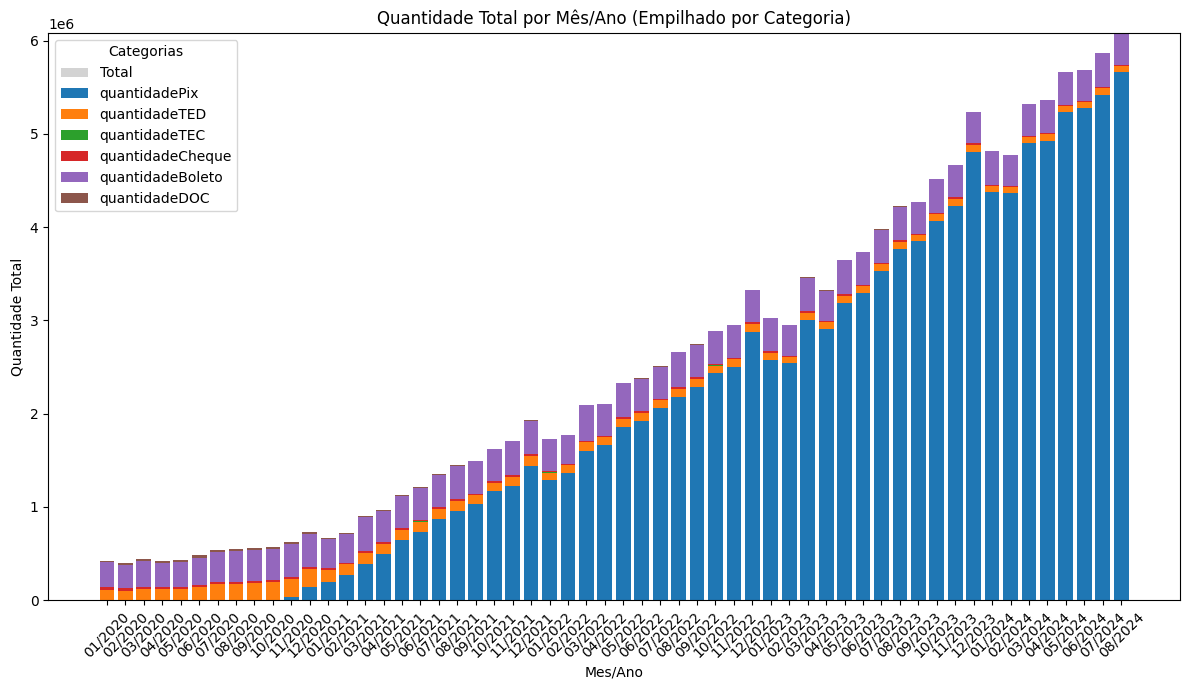

In [13]:
#Definição das colunas a serem plotadas neste gráfico
categorias = ['quantidadePix', 'quantidadeTED', 'quantidadeTEC',
              'quantidadeCheque', 'quantidadeBoleto', 'quantidadeDOC']

# Definição do tamanho do gráfico
plt.figure(figsize=(12, 7))

# Especificação do gráfico de barras, eixo utilizando coluna MesAno e colunas especificadas a serem plotadas).
plt.bar(df_quantidade['MesAno'], df_quantidade[categorias].sum(axis=1), label='Total', color='lightgrey')

#Aqui uma criação de variável para que as colunas fiquem estacadas uma acima da outra.
bottom_values = [0] * len(df_quantidade)

#For utilizado para plotar cada coluna, utilizando o eixo x, a quantidade no valor y, e a posição da barra.
for categoria in categorias:
    plt.bar(df_quantidade['MesAno'], df_quantidade[categoria],
            bottom=bottom_values, label=categoria)
    bottom_values = [bottom + val for bottom, val in zip(bottom_values, df_quantidade[categoria])]

#Criação de título do gráfico e título dos eixos
plt.title('Quantidade Total por Mês/Ano (Empilhado por Categoria)')
plt.xlabel('Mes/Ano')
plt.ylabel('Quantidade Total')

#Criação da legenda das colunas
plt.legend(title='Categorias')

#Rotação do eixo x para melhor visualização.
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

É perceptível visualmente neste gráfico observar que a quantidade de transações de todos os métodos, com exceção do PIX, seguiu constante mês a mês. No entando, o PIX, a partir do final de 2020 cresceu significativamente em praticamente todos os meses, exponenciando em larga escala a quantidade total de transações realizadas no Brasil. Em número de transações, o PIX acelerou a quantidade de movimentações financeiras realizadas, sendo que em praticamente 4 anos de existência, multiplicou por 6 vezes a quantidade total de transações.

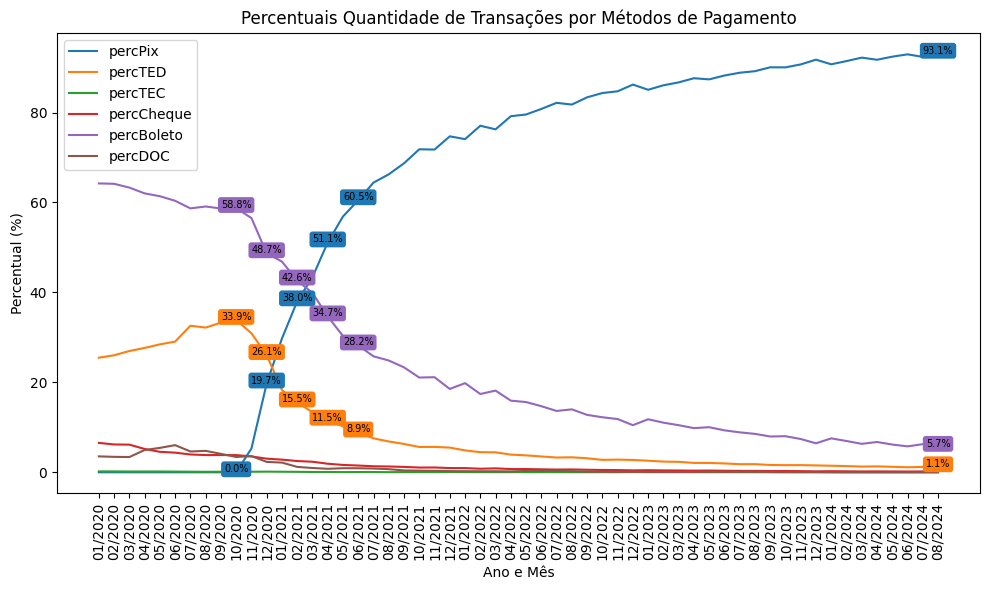

In [64]:
# Definindo o eixo x e as colunas que serão plotadas
x = df_quantidade['MesAno']
columns_to_plot = ['percPix', 'percTED', 'percTEC', 'percCheque', 'percBoleto', 'percDOC']

months_to_include = ['10/2020', '12/2020', '02/2021', '04/2021','06/2021','08/2024']
mask = x.isin(months_to_include)
x_filtered = x[mask]
df_filtered = df_quantidade[mask]

plt.figure(figsize=(10,6))


for col in columns_to_plot:
    plt.plot(x, df_quantidade[col], label=col)

    # Adicionando anotações para os pontos desejados apenas nas colunas especificadas
    if col in ['percPix', 'percBoleto', 'percTED']:
      for (x_val, y_val) in zip(x_filtered, df_filtered[col]):
            plt.annotate(
                f"{y_val:.1f}%",
                (x_val, y_val),
                textcoords="offset points",
                xytext=(0, 0),
                ha='center',
                fontsize=7,
                bbox=dict(boxstyle="round,pad=0.3",
                          edgecolor='none',
                          facecolor=plt.gca().lines[columns_to_plot.index(col)].get_color()))

# Adicionando título e rótulos
plt.title('Percentuais Quantidade de Transações por Métodos de Pagamento')
plt.xlabel('Ano e Mês')
plt.ylabel('Percentual (%)')

# Exibindo a legenda
plt.legend()

# Rotacionando o eixo x para melhor visualização, se necessário
plt.xticks(rotation=90)



# Exibindo o gráfico
plt.tight_layout()
plt.show()

Neste gráfico vemos o crescimento percentual na quantidade de transações logo no ínicio da implementação do PIX. Em outubro de 2021, Boleto era a modalidade líder, com 58% das transações e TED com 34% e PIX 0%. Após apenas 6 meses, o Pix se consolida como principal modalidade financeira, atingindo 51% de todas as transações, enquanto Boleto cai para 34% e Ted para 15%. No último mês, em agosto de 2024, percebemos como em quantidade de transações o PIX se consolidou atingindo 93%, enquanto Boleto com 5,7% e TED 1,1%.

## VALOR TOTAL DAS TRANSAÇÕES

In [62]:
print(df_valor.columns)

Index(['MesAno', 'valorPix', 'valorTED', 'valorTEC', 'valorCheque',
       'valorBoleto', 'valorDOC', 'valorTotal', 'percPix', 'percTED',
       'percTEC', 'percCheque', 'percBoleto', 'percDOC'],
      dtype='object')


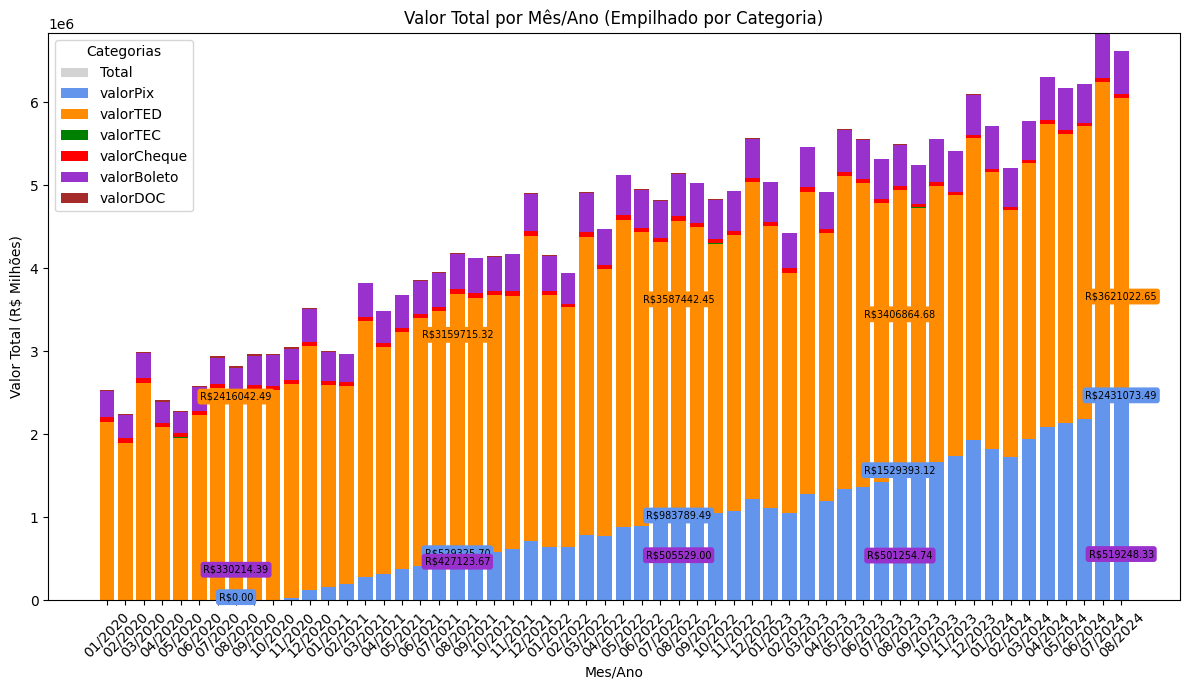

In [92]:
#Definição das colunas a serem plotadas neste gráfico
categorias = ['valorPix', 'valorTED', 'valorTEC',
              'valorCheque', 'valorBoleto', 'valorDOC']

months_to_include = ['08/2020', '08/2021', '08/2022', '08/2023','08/2024']
mask = df_valor['MesAno'].isin(months_to_include)  # Ensure you're filtering the DataFrame based on 'MesAno'
x_filtered = df_valor['MesAno'][mask]  # Use 'MesAno' directly for x values
df_filtered = df_valor[mask]
colors = ['cornflowerblue', 'darkorange', 'green', 'red', 'darkorchid', 'brown']
# Definição do tamanho do gráfico
plt.figure(figsize=(12, 7))

# Especificação do gráfico de barras, eixo utilizando coluna MesAno e colunas especificadas a serem plotadas).
plt.bar(df_valor['MesAno'], df_valor[categorias].sum(axis=1), label='Total', color='lightgrey')

#Aqui uma criação de variável para que as colunas fiquem estacadas uma acima da outra.
bottom_values = [0] * len(df_valor)

#For utilizado para plotar cada coluna, utilizando o eixo x, a quantidade no valor y, e a posição da barra.
for i, categoria in enumerate(categorias):
    plt.bar(df_valor['MesAno'], df_valor[categoria],
            bottom=bottom_values, label=categoria, color = colors[i])
    bottom_values = [bottom + val for bottom, val in zip(bottom_values, df_valor[categoria])]

    # Adicionando anotações para os pontos desejados apenas nas colunas especificadas
    if categoria in ['valorPix', 'valorBoleto', 'valorTED']:

      for (x_val, y_val) in zip(x_filtered, df_filtered[categoria]):
            plt.annotate(
                f"R${y_val:.2f}",
                (x_val, y_val),
                textcoords="offset points",
                xytext=(0, 0),
                ha='center',
                fontsize=7,
                bbox=dict(boxstyle="round,pad=0.3",
                          edgecolor='none',
                          facecolor=colors[i]))

#Criação de título do gráfico e título dos eixos
plt.title('Valor Total por Mês/Ano (Empilhado por Categoria)')
plt.xlabel('Mes/Ano')
plt.ylabel('Valor Total (R$ Milhões)')

#Criação da legenda das colunas
plt.legend(title='Categorias')

#Rotação do eixo x para melhor visualização.
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

Através deste gráfico, é possível perceber que apesar do crescimento do PIX, em valor monetário total o TED ainda é muito mais representativo. Além disso, apesar do boleto e TED terem caído percentualmente, o boleto segue sua média com uma leve crescente e o TED ainda subindo significativamente, atingindo 3,6 trilhões de reais movimentados em agosto de 2024. Enquanto isso, o boleto em 0,5 trilhões e o PIX com 2,4 trilhões,  subindo quase 1 trilhão desde agosto do ano passado.

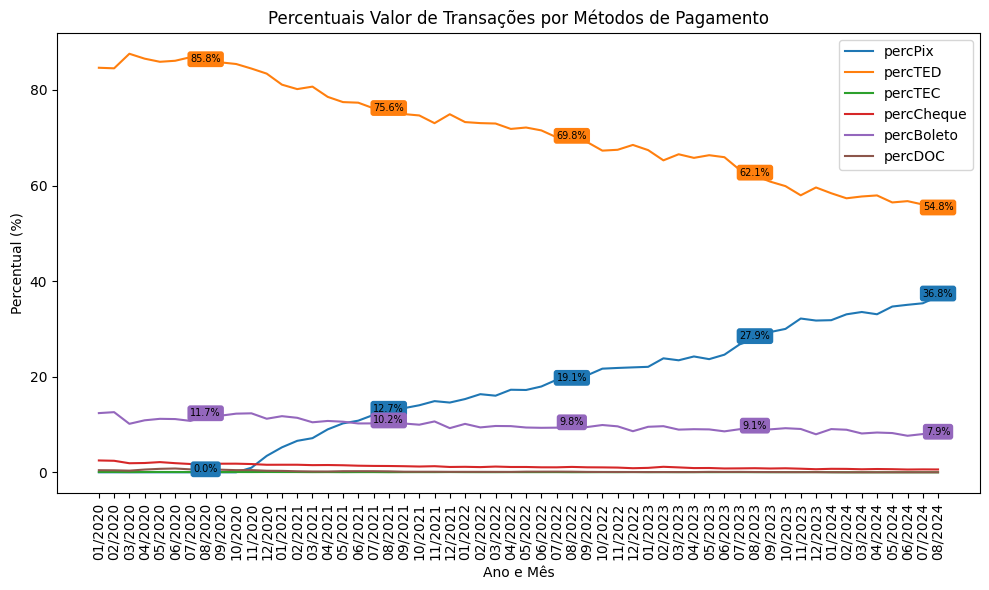

In [91]:
# Definindo o eixo x e as colunas que serão plotadas
x = df_valor['MesAno']
columns_to_plot = ['percPix', 'percTED', 'percTEC', 'percCheque', 'percBoleto', 'percDOC']

months_to_include = ['08/2020', '08/2021', '08/2022', '08/2023','08/2024']
mask = x.isin(months_to_include)
x_filtered = x[mask]
df_filtered = df_valor[mask]

plt.figure(figsize=(10,6))


for col in columns_to_plot:
    plt.plot(x, df_valor[col], label=col)

    # Adicionando anotações para os pontos desejados apenas nas colunas especificadas
    if col in ['percPix', 'percBoleto', 'percTED']:
      for (x_val, y_val) in zip(x_filtered, df_filtered[col]):
            plt.annotate(
                f"{y_val:.1f}%",
                (x_val, y_val),
                textcoords="offset points",
                xytext=(0, 0),
                ha='center',
                fontsize=7,
                bbox=dict(boxstyle="round,pad=0.3",
                          edgecolor='none',
                          facecolor=plt.gca().lines[columns_to_plot.index(col)].get_color()))

# Adicionando título e rótulos
plt.title('Percentuais Valor de Transações por Métodos de Pagamento')
plt.xlabel('Ano e Mês')
plt.ylabel('Percentual (%)')

# Exibindo a legenda
plt.legend()

# Rotacionando o eixo x para melhor visualização, se necessário
plt.xticks(rotation=90)



# Exibindo o gráfico
plt.tight_layout()
plt.show()

Aqui podemos perceber como o crescimento do PIX, em percentual monetário é mais tímido do que na quantidade de transações, apesar de ainda ter um crescimento significativo. Boleto, a modalidade que era a mais utilizada até início de 2021, perdeu apenas 4% no montante total nesses 4 anos. A modalidade TED, ainda que dominante caiu de 85% para 55%, mas ainda se mantendo a mais utilizada. O PIX com um crescimento médio de quase 10% ao ano, tende a atingir 40% do volume financeiro até o final do ano de 2024.

## TICKET MÉDIO

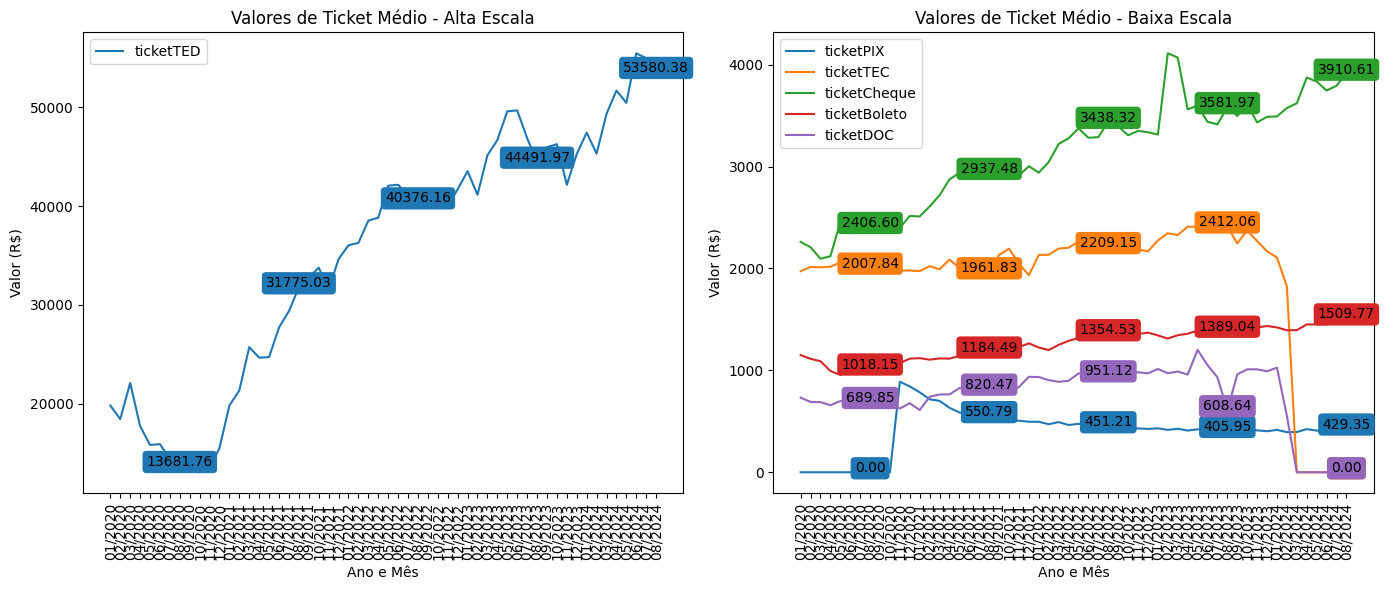

In [61]:
# Definindo o eixo x e as colunas que serão plotadas
x = df_ticket['MesAno']
columns_to_plot_high = ['ticketTED']  # Supondo que 'ticketPIX' é a coluna de maior valor
columns_to_plot_low = ['ticketPIX', 'ticketTEC', 'ticketCheque', 'ticketBoleto', 'ticketDOC']


months_to_include = ['08/2020', '08/2021', '08/2022', '08/2023','08/2024']
mask = x.isin(months_to_include)
x_filtered = x[mask]
df_filtered = df_ticket[mask]

# Criando subplots - dois gráficos no mesmo espaço
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# Primeiro gráfico para a coluna de alta escala
for col in columns_to_plot_high:
    ax1.plot(x, df_ticket[col], label=col)
    line_color = ax1.lines[-1].get_color()
    for (x_val, y_val) in zip(x_filtered, df_filtered[col]):
          ax1.annotate(
              f"{y_val:.2f}",
              (x_val, y_val),
              textcoords="offset points",
              xytext=(0, 0),
              ha='center',
              fontsize=10,
              bbox=dict(boxstyle="round,pad=0.3",
                        edgecolor='none',
                        facecolor=line_color))

ax1.set_title('Valores de Ticket Médio - Alta Escala')
ax1.set_xlabel('Ano e Mês')
ax1.set_ylabel('Valor (R$)')
ax1.legend()
ax1.tick_params(axis='x', rotation=90)  # Rotacionando o eixo x

# Segundo gráfico para as colunas de baixa escala
for col in columns_to_plot_low:
    ax2.plot(x, df_ticket[col], label=col)
    for (x_val, y_val) in zip(x_filtered, df_filtered[col]):
          ax2.annotate(
              f"{y_val:.2f}",
              (x_val, y_val),
              textcoords="offset points",
              xytext=(0, 0),
              ha='center',
              fontsize=10,
              bbox=dict(boxstyle="round,pad=0.3",
                        edgecolor='none',
                        facecolor=plt.gca().lines[columns_to_plot_low.index(col)].get_color()))

ax2.set_title('Valores de Ticket Médio - Baixa Escala')
ax2.set_xlabel('Ano e Mês')
ax2.set_ylabel('Valor (R$)')
ax2.legend()
ax2.tick_params(axis='x', rotation=90)  # Rotacionando o eixo x

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo os gráficos
plt.show()


Na primeira plotagem deste gráfico, percebemos que o ticket médio para a modalidade TED era de uma escala bem maior que as outras. Por isso, foi separado em duas plotagens, segregando TED das outras modalidades. Percebemos portanto que o uso do TED é costumeiramente para transações financeiras, e o do PIX segue como a modalidade de ticket médio mais baixo. Apesar do seu extenso crescimento de utilizações durante os 4 anos, o ticket médio de PIX se manteve em torno de 400 reais, enquanto todas as outras transações com valores significativos acima. Foram plotadas nos gráficos todas as médias nos meses de agosto de 2020 a 2024.